# OverView

BaseModel:https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-train-amp-aug<br>
Inferece part: https://www.kaggle.com/khyeh0719/pytorch-efficientnet-baseline-inference-tta

confirm inferece:https://www.kaggle.com/harininarasimhan/why-not-to-trust-public-lb-visualization


In [1]:
package_paths = [
    'input/FMix-master'
]
import sys; 

for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from warmup_scheduler import GradualWarmupScheduler
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom
from catalyst.data.sampler import BalanceClassSampler
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)
from albumentations.pytorch import ToTensorV2

In [24]:
CFG = {
    'input_path': 'input/cassava-leaf-disease-classification/',
    #'weight_path': '../weight/',
    'version': 'gcp_v2',
    'fold_num': 1,
    #'FOLDS': [0,1,2,3,4],
    'seed': 69,
    'model_arch': 'tf_efficientnet_b4_ns',
    'loss': 'Smoothed Cross Entropy Loss', # reference: https://www.kaggle.com/c/siim-isic-melanoma-classification/discussion/173733
    'optimizer': 'Adam',
    'scheduler': 'GradualWarmupScheduler',
    'img_size': 256,
    'epochs': 10,
    'train_bs': 16,
    'valid_bs': 32,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay': 1e-6,
    'num_workers': 0, # set 0 if windows 
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0',
    'warmup_factor': 10,
    'warmup_epo': 1,
    'tta': 1,
    'used_epochs': [0],
    'weights': [1],
    'used_2class':[6,7,8,9]
}

In [28]:
train = pd.read_csv('train_folds.csv')
train.head()

image_id  label  kfold
0  1000015157.jpg      0    2.0
1  1000201771.jpg      3    1.0
2   100042118.jpg      1    1.0
3  1000723321.jpg      1    0.0
4  1000812911.jpg      3    4.0

In [29]:
train.label.value_counts()

3    13158
4     2577
2     2386
1     2189
0     1087
Name: label, dtype: int64

In [30]:
submission = pd.read_csv('input/cassava-leaf-disease-classification/sample_submission.csv')
submission.head()

image_id  label
0  2216849948.jpg      4

# Helper Functions

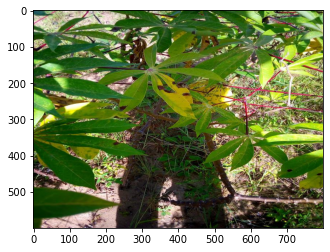

In [31]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('input/cassava-leaf-disease-classification/train_images/1000015157.jpg')
plt.imshow(img)
plt.show()

# Dataset

In [32]:
def rand_bbox(size, lam):
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

In [33]:
class CassavaDataset(Dataset):
    def __init__(
        self, df, data_root, transforms=None, output_label=True
    ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.output_label = output_label
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.df.iloc[index]['label']
          
        path = "{}/{}".format(self.data_root, self.df.iloc[index]['image_id'])
        
        img  = get_img(path)
        
        if self.transforms:
            img = self.transforms(image=img)['image']
            
        # do label smoothing
        if self.output_label == True:
            return img, target
        else:
            return img

In [34]:
def prepare_dataloader(df, fold, mode, do_cutmix=True, data_root=CFG['input_path'] + 'train_images/'):
    
    train_ = df[df['kfold']!=fold].reset_index(drop=True)
    valid_ = df[df['kfold']==fold].reset_index(drop=True)
        
    do_cutmix = do_cutmix
    train_ds = CassavaDataset(train_, data_root, transforms=get_test_transforms(mode),
                              output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=do_cutmix)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_test_transforms(mode), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

# Define Train\Validation Image Augmentations

In [35]:
from albumentations import (
    HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, 
    ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

In [36]:
def get_test_transforms(mode):
    if mode == 0:
        return Compose([
                CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
                Resize(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.0)
    elif mode == 1:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)
    elif mode == 2:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)
    else:
        return Compose([
                RandomResizedCrop(CFG['img_size'], CFG['img_size']),
                Transpose(p=0.5),
                HorizontalFlip(p=0.5),
                VerticalFlip(p=0.5),
                HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
                RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
                ToTensorV2(p=1.0),
            ], p=1.)

# Model

In [37]:
class CassvaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

# Main Loop

In [38]:
def inference_one_epoch(model, data_loader, device):
    model.eval()

    image_preds_all = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    for step, (imgs) in pbar:
        imgs = imgs.to(device).float()
        
        image_preds = model(imgs)   #output = model(input)
        image_preds_all += [torch.softmax(image_preds, 1).detach().cpu().numpy()]
        
    
    image_preds_all = np.concatenate(image_preds_all, axis=0)
    return image_preds_all

In [39]:
def prepare_dataloader(df, fold, mode, do_cutmix=True, data_root=CFG['input_path'] + 'train_images/'):
    
    train_ = df[df['kfold']!=fold].reset_index(drop=True)
    valid_ = df[df['kfold']==fold].reset_index(drop=True)
        
    do_cutmix = do_cutmix
    train_ds = CassavaDataset(train_, data_root, transforms=get_test_transforms(mode),
                              output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=do_cutmix)
    valid_ds = CassavaDataset(valid_, data_root, transforms=get_test_transforms(mode), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=False,
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

In [ ]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch

    seed_everything(CFG['seed'])
    total_acc = 0

    for fold in range(CFG['fold_num']):

        print('Inference fold {} started'.format(fold))     
        device = torch.device(CFG['device'])
        model = CassvaImgClassifier(CFG['model_arch'], train.label.nunique()).to(device)
        
        valid_ = train[train['kfold']==fold].reset_index(drop=True)

        print('read model: {}_{}_best'.format(CFG['model_arch'], CFG['version']))
        model.load_state_dict(torch.load('{}_fold_{}_{}'.format(CFG['model_arch'], fold, 11)))

        val_preds = []
        with torch.no_grad():
            for mode in range(CFG['tta']):
                
                valid_ds = CassavaDataset(valid_, (CFG['input_path'] + 'train_images/'), 
                                          transforms=get_test_transforms(mode=mode), output_label=False)

                val_loader = torch.utils.data.DataLoader(
                    valid_ds, 
                    batch_size=CFG['valid_bs'],
                    num_workers=CFG['num_workers'],
                    shuffle=False,
                    pin_memory=False,
                )
                
                val_preds += [1/CFG['tta']*inference_one_epoch(model, val_loader, device)]
    
        val_preds = np.mean(val_preds, axis=0)
        total_acc += (valid_.label.values==np.argmax(val_preds, axis=1)).mean()
        print('fold {} validation loss = {:.5f}'.format(fold, log_loss(valid_.label.values, val_preds)))
        print('fold {} validation accuracy = {:.5f}'.format(fold, (valid_.label.values==np.argmax(val_preds, axis=1)).mean()))

        output_descriptor = val_preds
        output_label = valid_.label.values
        
        data = valid_.copy()
        data['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))  
        for i in range(0,5):
            _label_acc = data[(data['label']==data['predict_label']) & (data['predict_label']==i)].shape[0] /\
                                                                                                data[data['label']==i].shape[0]
            print('label:{} accuracy is {:.5f}'.format(i, _label_acc))

        del model
        torch.cuda.empty_cache()
        
print('Fold Ensemble Accuracy== {:.5f}'.format(total_acc/len(CFG['fold_num'])))

Inference fold 0 started
read model: tf_efficientnet_b4_ns_gcp_v2_best


 99%|█████████▉| 133/134 [01:54<00:00,  1.20it/s]

# Confirm Predictions

In [34]:
BASE_DIR = "../input/cassava-leaf-disease-classification/"
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind + 1)
        image = cv2.imread(os.path.join(BASE_DIR, "train_images", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"Class: {label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [35]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
print(disease_names)

data = valid_.copy()
data['disease_name'] = data['label'].apply(lambda x: disease_names[str(x)])
data['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))
data.head()

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}


image_id  label  kfold                  disease_name  predict_label
0  1000812911.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
1  1003298598.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
2  1004105566.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3
3   100472565.jpg      2    4.0    Cassava Green Mottle (CGM)              2
4   100533489.jpg      2    4.0    Cassava Green Mottle (CGM)              1

In [36]:
print('total data is{}'.format(data.shape))
for i in range(0,5):
    a = data[(data['label']== i) & (data['label']!=data['predict_label'])]
    print('Miss Label:{} is {}'.format(i, a.shape[0]))
    print(a['predict_label'].value_counts())

total data is(4279, 5)
Miss Label:0 is 68
4    40
1    17
3     7
2     4
Name: predict_label, dtype: int64
Miss Label:1 is 86
4    48
0    20
3    11
2     7
Name: predict_label, dtype: int64
Miss Label:2 is 97
3    48
4    28
1    12
0     9
Name: predict_label, dtype: int64
Miss Label:3 is 88
2    37
1    24
4    23
0     4
Name: predict_label, dtype: int64
Miss Label:4 is 116
0    45
3    26
2    26
1    19
Name: predict_label, dtype: int64


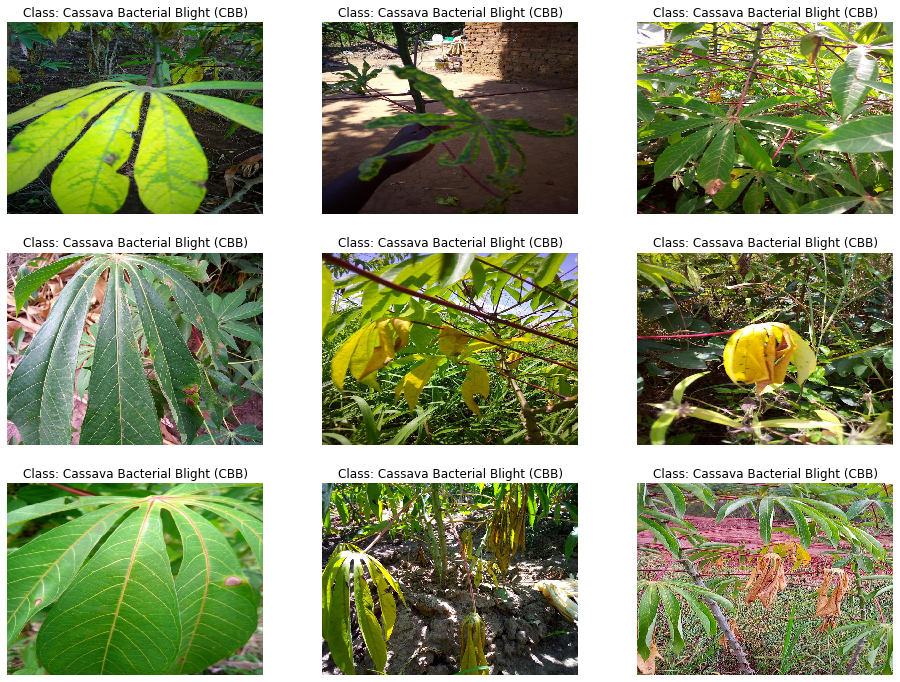

In [20]:
a = data[(data['label']== 0) & (data['label']!=data['predict_label'])]
image_ids = a["image_id"].values
labels = a["disease_name"].values

visualize_batch(image_ids[0:9], labels[0:9])

In [21]:
for i in range(0,5):
    print('■label{} accuracy'.format(i))
    print(data[(data['label']==data['predict_label']) & (data['predict_label']==i)].shape[0]/ data[data['label']==i].shape[0])

■label0 accuracy
0.6866359447004609
■label1 accuracy
0.8032036613272311
■label2 accuracy
0.797071129707113
■label3 accuracy
0.9665653495440729
■label4 accuracy
0.7747572815533981


# Denoising Data

In [22]:
threshold = 0.80

In [23]:
np.max(output_descriptor, axis=1)

array([0.9927142 , 0.8443778 , 0.9989924 , ..., 0.94403243, 0.8916106 ,
       0.5752934 ], dtype=float32)

In [24]:
one_fold = valid_.copy()
one_fold['disease_name'] = one_fold['label'].apply(lambda x: disease_names[str(x)])
one_fold['predict_label'] = pd.DataFrame(np.argmax(val_preds, axis=1))
one_fold['value'] = np.max(output_descriptor, axis=1)
one_fold.head()

image_id  label  kfold                  disease_name  predict_label  \
0  1000812911.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
1  1003298598.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
2  1004105566.jpg      3    4.0  Cassava Mosaic Disease (CMD)              3   
3   100472565.jpg      2    4.0    Cassava Green Mottle (CGM)              2   
4   100533489.jpg      2    4.0    Cassava Green Mottle (CGM)              1   

      value  
0  0.992714  
1  0.844378  
2  0.998992  
3  0.946825  
4  0.503878

In [25]:
mask1 = (one_fold["label"] != one_fold["predict_label"]) & (one_fold["value"] >= threshold)
one_list = one_fold[mask1].index.to_list()
print(len(one_list))

96


In [26]:
one_fold.iloc[one_list]

image_id  label  kfold                         disease_name  \
156   1138645276.jpg      4    4.0                              Healthy   
176   1153882793.jpg      1    4.0  Cassava Brown Streak Disease (CBSD)   
198   1171469131.jpg      4    4.0                              Healthy   
208   1179913576.jpg      0    4.0       Cassava Bacterial Blight (CBB)   
218   1184986094.jpg      2    4.0           Cassava Green Mottle (CGM)   
...              ...    ...    ...                                  ...   
4126   849184144.jpg      4    4.0                              Healthy   
4134   853854962.jpg      1    4.0  Cassava Brown Streak Disease (CBSD)   
4166   888355689.jpg      0    4.0       Cassava Bacterial Blight (CBB)   
4262   982241079.jpg      1    4.0  Cassava Brown Streak Disease (CBSD)   
4263   982556736.jpg      4    4.0                              Healthy   

      predict_label     value  
156               3  0.927882  
176               4  0.845292  
198               0  0.862648  
208               3  0.858893  
218               3  0.999932  
...             ...       ...  
4126              3  0.828655  
4134              4  0.891748  
4166              4  0.802799  
4262              4  0.833446  
4263              0  0.907787  

[96 rows x 6 columns]

In [27]:
a = one_fold.iloc[one_list]
print(a.shape[0])
print(a[a['label']==0].shape[0])
print(a[a['label']==4].shape[0])
a[a['label']==4]

96
12
30


image_id  label  kfold disease_name  predict_label     value
156   1138645276.jpg      4    4.0      Healthy              3  0.927882
198   1171469131.jpg      4    4.0      Healthy              0  0.862648
356   1302328544.jpg      4    4.0      Healthy              3  0.831182
401   1341694459.jpg      4    4.0      Healthy              3  0.865836
446   1365612235.jpg      4    4.0      Healthy              3  0.944689
466   1385808202.jpg      4    4.0      Healthy              3  0.969480
470   1386911368.jpg      4    4.0      Healthy              0  0.921522
479   1395866975.jpg      4    4.0      Healthy              1  0.923293
686   1562043567.jpg      4    4.0      Healthy              0  0.846812
948   1807049681.jpg      4    4.0      Healthy              2  0.885428
1046  1891755915.jpg      4    4.0      Healthy              3  0.882433
1065  1903950320.jpg      4    4.0      Healthy              3  0.975253
1115  1947904134.jpg      4    4.0      Healthy              0  0.833105
1125  1954353329.jpg      4    4.0      Healthy              3  0.884545
1217  2033648478.jpg      4    4.0      Healthy              3  0.922143
1339  2154826831.jpg      4    4.0      Healthy              3  0.886392
1557  2329257679.jpg      4    4.0      Healthy              0  0.902896
1635  2406398124.jpg      4    4.0      Healthy              1  0.844801
1993  2715221153.jpg      4    4.0      Healthy              3  0.995303
2029  2757300199.jpg      4    4.0      Healthy              1  0.802742
2056  2793573567.jpg      4    4.0      Healthy              0  0.885230
2167  2901223259.jpg      4    4.0      Healthy              1  0.842122
2707  3370597486.jpg      4    4.0      Healthy              3  0.908855
2775  3441418915.jpg      4    4.0      Healthy              0  0.869007
2888   354756762.jpg      4    4.0      Healthy              3  0.905818
2945  3601095535.jpg      4    4.0      Healthy              3  0.879788
3187  3831055532.jpg      4    4.0      Healthy              0  0.866648
3707   478546048.jpg      4    4.0      Healthy              2  0.909947
4126   849184144.jpg      4    4.0      Healthy              3  0.828655
4263   982556736.jpg      4    4.0      Healthy              0  0.907787

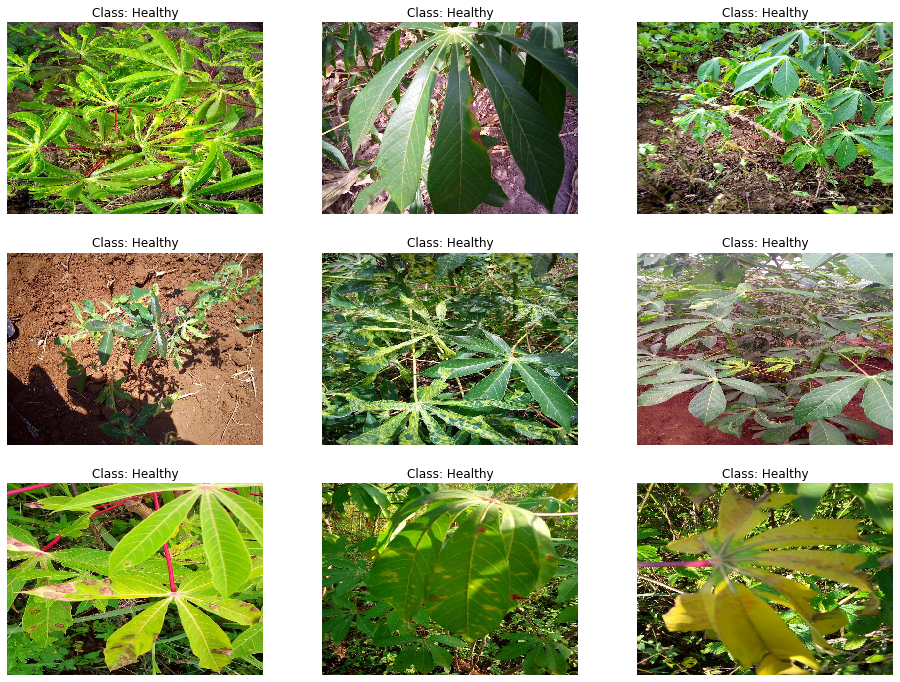

In [28]:
i=4
image_ids = a[a['label']==i]["image_id"].values
labels = a[a['label']==i]["disease_name"].values

visualize_batch(image_ids[0:9], labels[0:9])

## TSNE

In [29]:
from sklearn.manifold import TSNE

st_time = time.time()
t_sne = TSNE(random_state=2020)
t_sne_tr = t_sne.fit_transform(output_descriptor)
print('TNSE done; Time take {} seconds'.format(time.time()-st_time))

TNSE done; Time take 7.251005411148071 seconds


In [30]:
import json
#maping the class labels mentioned in json file wiht its respective disease name
disease_names = open('../input/cassava-leaf-disease-classification/'+'label_num_to_disease_map.json')
disease_names = json.load(disease_names)
disease_names

{'0': 'Cassava Bacterial Blight (CBB)',
 '1': 'Cassava Brown Streak Disease (CBSD)',
 '2': 'Cassava Green Mottle (CGM)',
 '3': 'Cassava Mosaic Disease (CMD)',
 '4': 'Healthy'}

In [31]:
tsne_tr = pd.DataFrame()
for idx in range(t_sne_tr.shape[1]):
    tsne_tr['t_sne'+str(idx+1)] = t_sne_tr[:,idx]
tsne_tr['label'] = output_label.astype(int)
tsne_tr['disease_name'] = tsne_tr['label'].apply(lambda x: disease_names[str(x)])
tsne_tr.head()

t_sne1     t_sne2  label                  disease_name
0 -15.556097 -57.042217      3  Cassava Mosaic Disease (CMD)
1  65.338860   7.221313      3  Cassava Mosaic Disease (CMD)
2  26.229210 -66.876282      3  Cassava Mosaic Disease (CMD)
3 -13.361784  75.770569      2    Cassava Green Mottle (CGM)
4 -11.958619 -14.849276      2    Cassava Green Mottle (CGM)

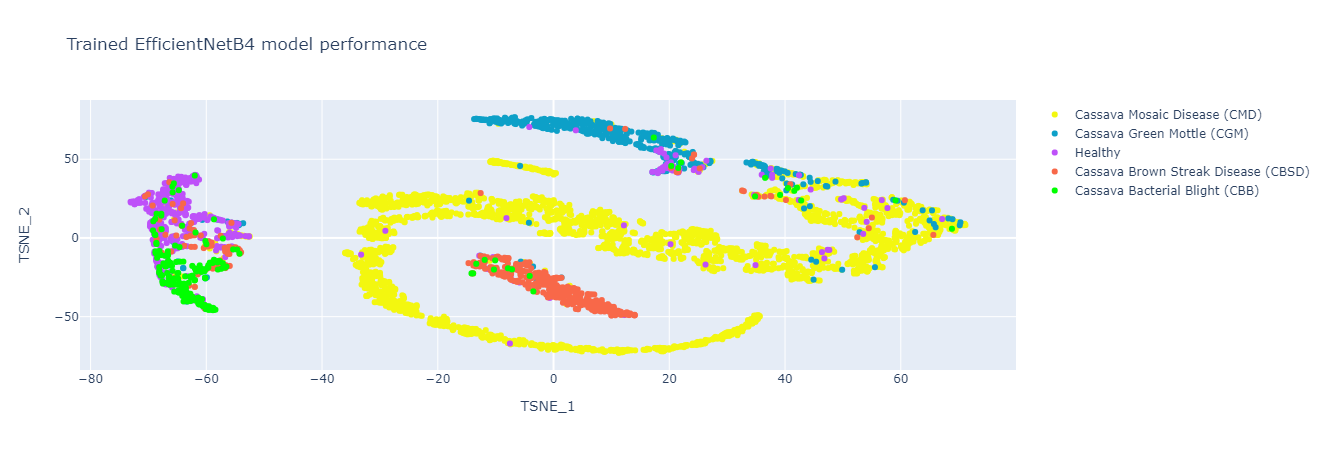

In [32]:
import plotly.graph_objects as go
fig = go.Figure()
colors = ['rgb(243, 247, 15)','rgb(13, 160, 200)','rgb(190, 81, 249)','rgb(248, 104, 73)','rgb(0,255,0)']
for idx,dn in enumerate(tsne_tr['disease_name'].unique()):
    df = tsne_tr[tsne_tr['disease_name'] == dn]
    fig.add_trace(go.Scatter(x=df['t_sne1'],y=df['t_sne2'],mode='markers',marker_color = colors[idx],name=dn))
fig.update_layout(title='Trained EfficientNetB4 model performance')
fig.update_xaxes(title_text="TSNE_1")
fig.update_yaxes(title_text="TSNE_2")
fig.show()

In [33]:
print(disease_names)

{'0': 'Cassava Bacterial Blight (CBB)', '1': 'Cassava Brown Streak Disease (CBSD)', '2': 'Cassava Green Mottle (CGM)', '3': 'Cassava Mosaic Disease (CMD)', '4': 'Healthy'}
